In [67]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.tft import TemporalFusionTransformerEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")
dataset = get_dataset("solar-energy", regenerate=False)

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [41]:
tourism = pd.read_csv("cleaned_tourism.csv")
print(tourism.shape)
pd.concat([tourism.head(), tourism.tail()])

(6460, 4)


,quarter,region,state,trips
0,1998-01-01,Adelaide,SA,658.553895
1,1998-01-01,Adelaide_Hills,SA,9.798630
2,1998-01-01,Alice_Springs,NT,20.207638
3,1998-01-01,Australias_Coral_Coast,WA,132.516409
4,1998-01-01,Australias_Golden_Outback,WA,161.726948
6455,2015-10-01,total,total,25759.429177
6456,2016-01-01,total,total,27492.360374
6457,2016-04-01,total,total,24791.797758
6458,2016-07-01,total,total,24696.079808
6459,2016-10-01,total,total,27017.077807


In [8]:
tourism.groupby(["region", "state"]).count().describe()

,quarter,trips
count,85.0,85.0
mean,76.0,76.0
std,0.0,0.0
min,76.0,76.0
25%,76.0,76.0
50%,76.0,76.0
75%,76.0,76.0
max,76.0,76.0


In [79]:
metadata = {
    "prediction_length": 4,
    "max_context_length": 4*4,
    "freq": "1Q",
    "ts_keys": ["state", "region"],
    "response": "trips",
    "time_col": "quarter",
    "cat_cols": ["state", "region"]
}

In [61]:
train_df = tourism.groupby(metadata["ts_keys"], as_index=False).apply(lambda x: x.iloc[:-metadata["prediction_length"]]).reset_index(drop=True)
train_df.shape
test_df = tourism

In [80]:
#reconfigure test
tourism.groupby(metadata["ts_keys"], as_index=False)[metadata["time_col"]].max()

,state,region,quarter
0,0.0,14.0,2016-10-01
1,0.0,77.0,2016-10-01
2,1.0,11.0,2016-10-01
3,1.0,15.0,2016-10-01
4,1.0,16.0,2016-10-01
...,...,...,...
80,6.0,5.0,2016-10-01
81,6.0,6.0,2016-10-01
82,6.0,25.0,2016-10-01
83,6.0,77.0,2016-10-01


In [62]:
column_trans = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 9999), metadata["cat_cols"])
)
train_df[metadata["cat_cols"]] = column_trans.fit_transform(train_df)
test_df[metadata["cat_cols"]] = column_trans.fit_transform(test_df)


In [63]:
def create_list_dataset(df, metadata):
    return ListDataset(
        [
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_STATIC_CAT: fsc
            }
            for (target, start, fsc) in zip(
                df[metadata["ts_keys"] + [metadata["response"]]].pivot_table(index=metadata["ts_keys"], aggfunc=list)[metadata["response"]],
                df.groupby(metadata["ts_keys"])[metadata["time_col"]].min(),
                df.groupby(metadata["ts_keys"])[[c for c in metadata["cat_cols"]]].max().values
            )
        ],
        freq=metadata['freq']
    )

In [65]:
train_ds = create_list_dataset(train_df, metadata)
print(next(iter(train_ds)))
test_ds = create_list_dataset(test_df, metadata)
next(iter(test_ds))


{'target': array([551.0019 , 416.02563, 436.02902, 449.79843, 378.5728 , 558.17816,
       448.90118, 594.82544, 599.6685 , 557.1351 , 440.0144 , 494.37943,
       390.5585 , 618.3817 , 547.0309 , 532.9225 , 448.50232, 547.3487 ,
       456.0747 , 521.87024, 378.33597, 445.8928 , 540.20996, 580.2373 ,
       492.1421 , 483.45148, 423.89532, 481.6145 , 517.944  , 478.37164,
       567.77185, 423.1985 , 447.95407, 549.9349 , 454.97165, 439.9281 ,
       495.2575 , 476.01962, 522.7008 , 461.29462, 474.23895, 482.65582,
       529.4967 , 469.8418 , 492.5086 , 396.74985, 410.15533, 427.8558 ,
       616.8148 , 554.71844, 443.82385, 465.30893, 380.90042, 447.54803,
       495.3908 , 475.54828, 446.90454, 456.80197, 521.83673, 511.76605,
       524.5536 , 475.5325 ], dtype=float32), 'start': Timestamp('1998-03-31 00:00:00', freq='Q-DEC'), 'feat_static_cat': array([ 0, 14]), 'source': SourceContext(source='list_data', row=0)}


{'target': array([551.0019 , 416.02563, 436.02902, 449.79843, 378.5728 , 558.17816,
        448.90118, 594.82544, 599.6685 , 557.1351 , 440.0144 , 494.37943,
        390.5585 , 618.3817 , 547.0309 , 532.9225 , 448.50232, 547.3487 ,
        456.0747 , 521.87024, 378.33597, 445.8928 , 540.20996, 580.2373 ,
        492.1421 , 483.45148, 423.89532, 481.6145 , 517.944  , 478.37164,
        567.77185, 423.1985 , 447.95407, 549.9349 , 454.97165, 439.9281 ,
        495.2575 , 476.01962, 522.7008 , 461.29462, 474.23895, 482.65582,
        529.4967 , 469.8418 , 492.5086 , 396.74985, 410.15533, 427.8558 ,
        616.8148 , 554.71844, 443.82385, 465.30893, 380.90042, 447.54803,
        495.3908 , 475.54828, 446.90454, 456.80197, 521.83673, 511.76605,
        524.5536 , 475.5325 , 506.5121 , 529.58453, 444.2715 , 517.4469 ,
        528.2779 , 466.93518, 526.9548 , 513.4561 , 611.8143 , 542.76965,
        626.6406 , 592.6085 , 572.4371 , 667.2141 ], dtype=float32),
 'start': Timestamp('1998-03-31 0

C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\dataset\util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


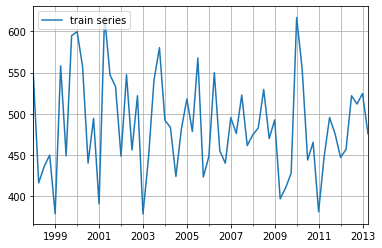

In [13]:
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [68]:
deepar_est = DeepAREstimator(
    freq=metadata["freq"],
    prediction_length=metadata["prediction_length"],
    context_length=metadata["prediction_length"]*3,
    num_layers=2,
    num_cells=40,
    cell_type="lstm",
    dropout_rate=0.1,
    use_feat_dynamic_real=False,
    use_feat_static_cat=True,
    use_feat_static_real=False,
    cardinality=[int(train_df[cat].max() + 1) for cat in metadata["cat_cols"]],
    embedding_dimension=[10 for _ in range(len(metadata["cat_cols"]))],
    distr_output=StudentTOutput(),
    scaling=True,
    time_features=None,
    trainer=Trainer(
        epochs=100,
        num_batches_per_epoch=60,
        batch_size=32,
        learning_rate=0.01,
        patience=5,
        learning_rate_decay_factor=0.7,
        minimum_learning_rate=0.001
    )
)
deepar_predictor = deepar_est.train(training_data=train_ds, validation_data=test_ds)

C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/60 [00:00<?, ?it/s]C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluont

Early stopping based on learning rate scheduler callback (min_lr was reached).


In [ ]:
tft_est = TemporalFusionTransformerEstimator(
    freq=metadata["freq"],
    prediction_length=metadata["prediction_length"],
    context_length=metadata["prediction_length"]*3,
    num_heads=4,
    num_outputs=3,
    num_instances_per_series=100,#TODO

    hidden_dim=32,
    variable_dim=None,#TODO
    time_features=[],
    dropout_rate=0.1,
    static_cardinalities=[int(train_df[cat].max() + 1) for cat in metadata["cat_cols"]],
    dynamic_cardinalities={},
    static_feature_dims=[10 for _ in range(len(metadata["cat_cols"]))],
    dynamic_feature_dims={},
    past_dynamic_features={},
    distr_output=StudentTOutput(),
    scaling=True,
    time_features=None,
    trainer=Trainer(
        epochs=100,
        num_batches_per_epoch=60,
        batch_size=32,
        learning_rate=0.01,
        patience=20,
        learning_rate_decay_factor=0.7,
        minimum_learning_rate=0.001
    )
)
tft_predictor = tft_est.train(training_data=train_ds, validation_data=test_ds)

In [72]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepar_predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\transform\feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


In [73]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

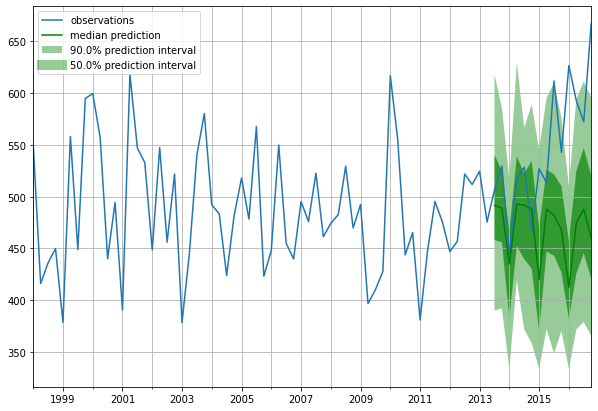

In [74]:
plot_prob_forecasts(tss[0], forecasts[0])

In [75]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(train_ds))

Running evaluation:   0%|          | 0/85 [00:00<?, ?it/s]C:\Users\Jason\anaconda3\envs\mult-for\lib\site-packages\gluonts\evaluation\_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 100%|██████████| 85/85 [00:00<00:00, 167.33it/s]


In [76]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 214988.07959010018,
    "abs_error": 155476.07474517822,
    "abs_target_sum": 1015368.7021484375,
    "abs_target_mean": 853.251010208771,
    "seasonal_error": 58.95574812511886,
    "MASE": 1.4722455505596395,
    "MAPE": 0.20929483580990002,
    "sMAPE": 0.22979706490741053,
    "MSIS": 14.179821074462986,
    "QuantileLoss[0.1]": 51496.52696900367,
    "Coverage[0.1]": 0.026050420168067228,
    "QuantileLoss[0.5]": 155476.0775847435,
    "Coverage[0.5]": 0.22268907563025211,
    "QuantileLoss[0.9]": 134239.99036102294,
    "Coverage[0.9]": 0.5890756302521009,
    "RMSE": 463.668070488038,
    "NRMSE": 0.5434134445086551,
    "ND": 0.15312277640250632,
    "wQuantileLoss[0.1]": 0.05071707140474314,
    "wQuantileLoss[0.5]": 0.1531227791990917,
    "wQuantileLoss[0.9]": 0.13220812309556326,
    "mean_absolute_QuantileLoss": 113737.5316382567,
    "mean_wQuantileLoss": 0.1120159912331327,
    "MAE_Coverage": 0.22072829131652663,
    "OWA": NaN
}


In [77]:
print(item_metrics.shape)
item_metrics.head()


(85, 16)


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,9974.789062,1107.759033,7646.922852,546.208775,71.498998,1.106668,0.135009,0.151236,9.727434,435.340442,0.0,1107.759033,0.071429,649.065143,0.642857
1,NaN,9829.319196,1070.474121,7646.922852,546.208775,71.498998,1.069420,0.130631,0.145659,10.776861,429.521869,0.0,1070.474121,0.071429,746.261792,0.571429
2,NaN,5871.421875,971.592285,2979.319092,212.808507,32.600769,2.128767,0.307847,0.373585,19.330235,302.724435,0.0,971.592278,0.000000,752.458652,0.142857
3,NaN,5341.844308,905.208618,4149.697754,296.406982,30.745151,2.103023,0.208819,0.238496,18.965204,299.143005,0.0,905.208603,0.000000,646.141461,0.357143
4,NaN,1631.369001,477.242981,4567.682617,326.263044,40.296374,0.845952,0.102141,0.103980,5.291961,211.810620,0.0,477.242950,0.500000,177.147906,0.857143


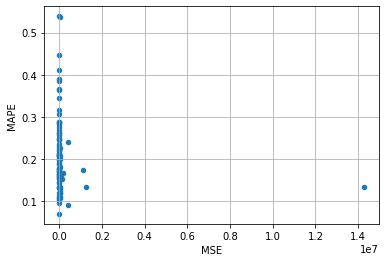

In [78]:
item_metrics.plot(x='MSE', y='MAPE', kind='scatter')
plt.grid(which="both")
plt.show()